## Make data

In [41]:
%%file data.scons

Flow('trace',None,'spike n1=2001 d1=0.001 k1=1001 | ricker1 frequency=30')
Flow('gather','trace','spray axis=2 n=49 d=25 o=0 label=Offset unit=m | nmostretch inv=y half=n v0=2000')

Result('gather','window f1=888 n1=392 | grey title=Gather')


Overwriting data.scons


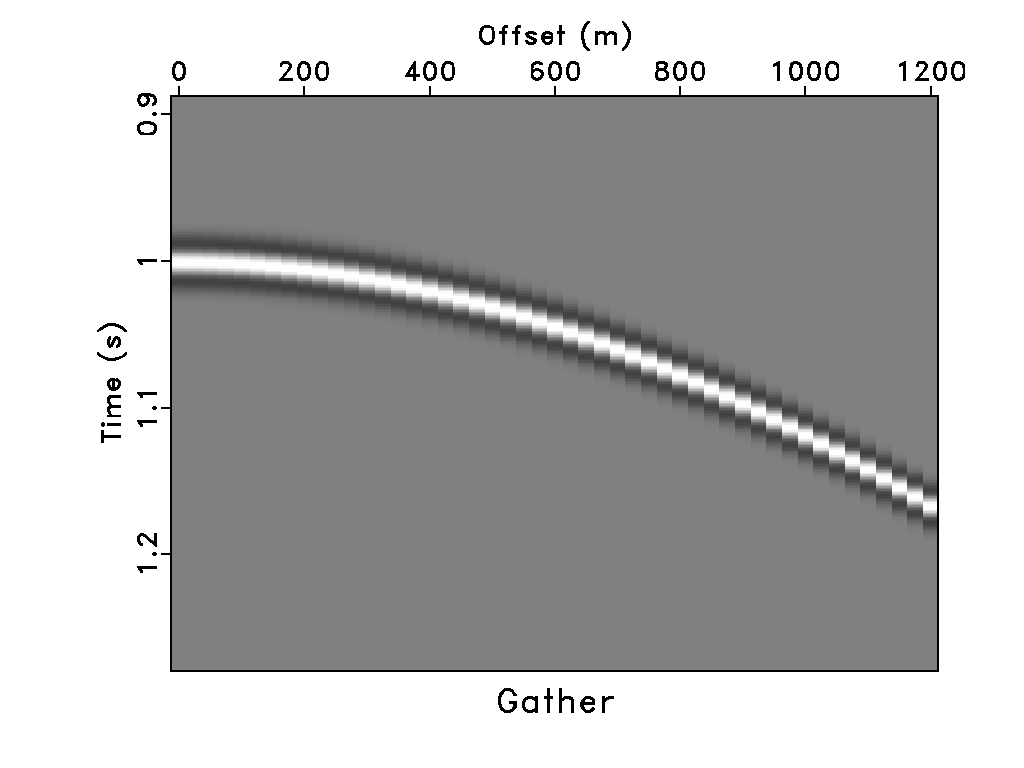

In [1]:
from m8r import view
view('gather')

Display the same with Python (matplotlib)

In [43]:
import m8r
gather = m8r.File('gather.rsf')

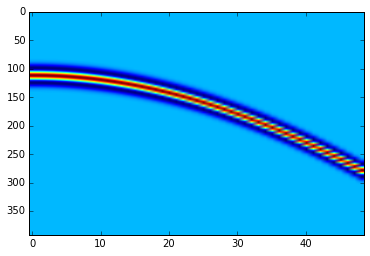

In [44]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
plt.imshow(np.transpose(gather[:,888:1280]),aspect='auto')

## Apply moveout with incorrect velocity

In [47]:
%%file nmo.scons

Flow('nmo','gather','nmostretch half=n v0=1800')

Result('nmo','window f1=888 n1=200 | grey title=NMO')

Overwriting nmo.scons


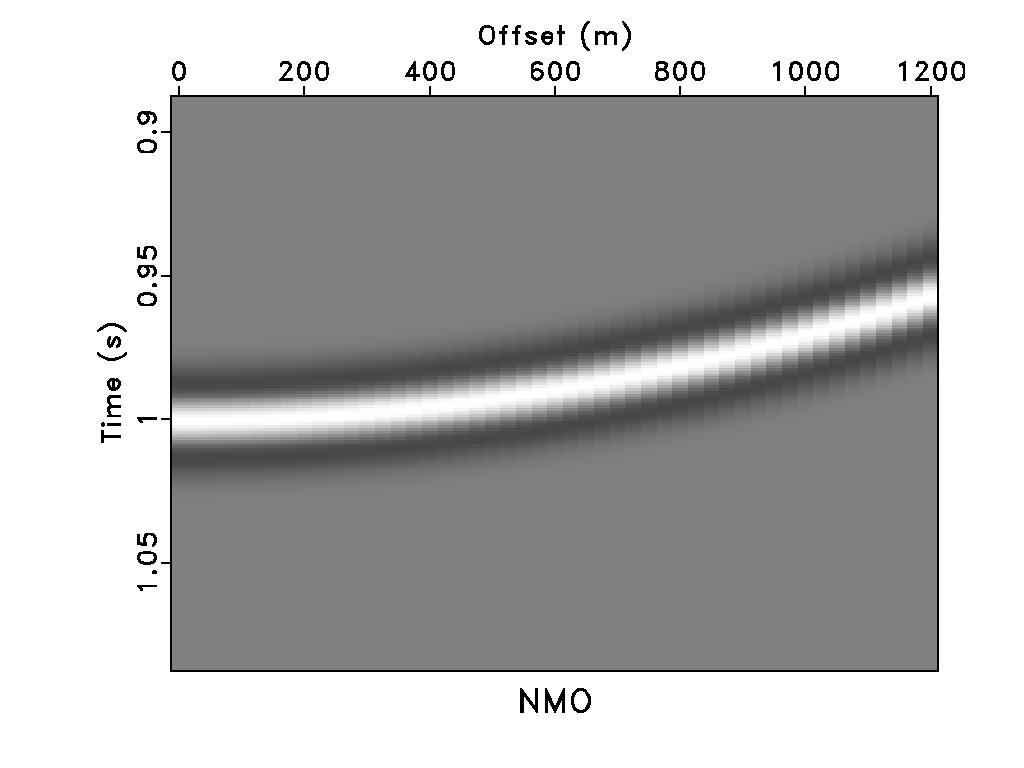

In [48]:
view('nmo')

## Slope estimation

In [51]:
%%file slope.scons

Flow('slope','nmo','dip rect1=100 rect2=5 order=2')

Result('slope','grey color=linearlfb mean=y scalebar=y title=Slope')

Overwriting slope.scons


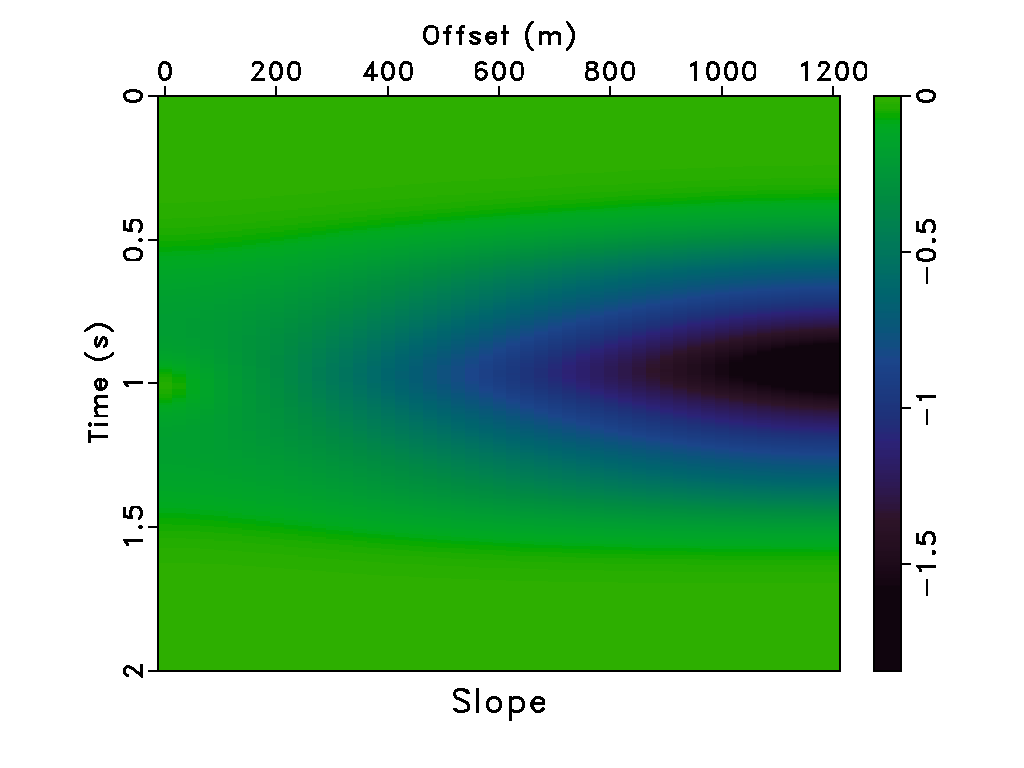

In [52]:
view('slope')

## Non-physical flattening by predictive painting

In [59]:
%%file flat.scons

Flow('paint','slope','pwpaint order=2')

Result('paint','window f1=888 n1=200 | contour title=Painting')

Flow('flat','nmo paint','iwarp warp=${SOURCES[1]}')

Result('flat','window f1=888 n1=200 | grey title=Flattening')

Overwriting flat.scons


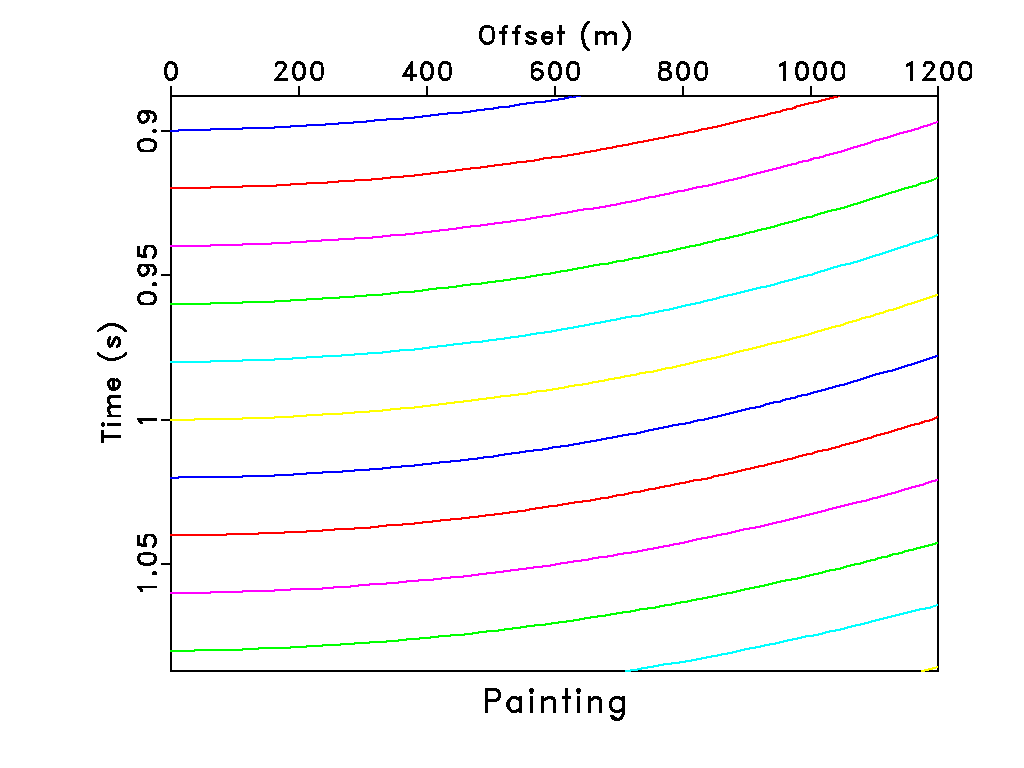

In [58]:
view('paint')

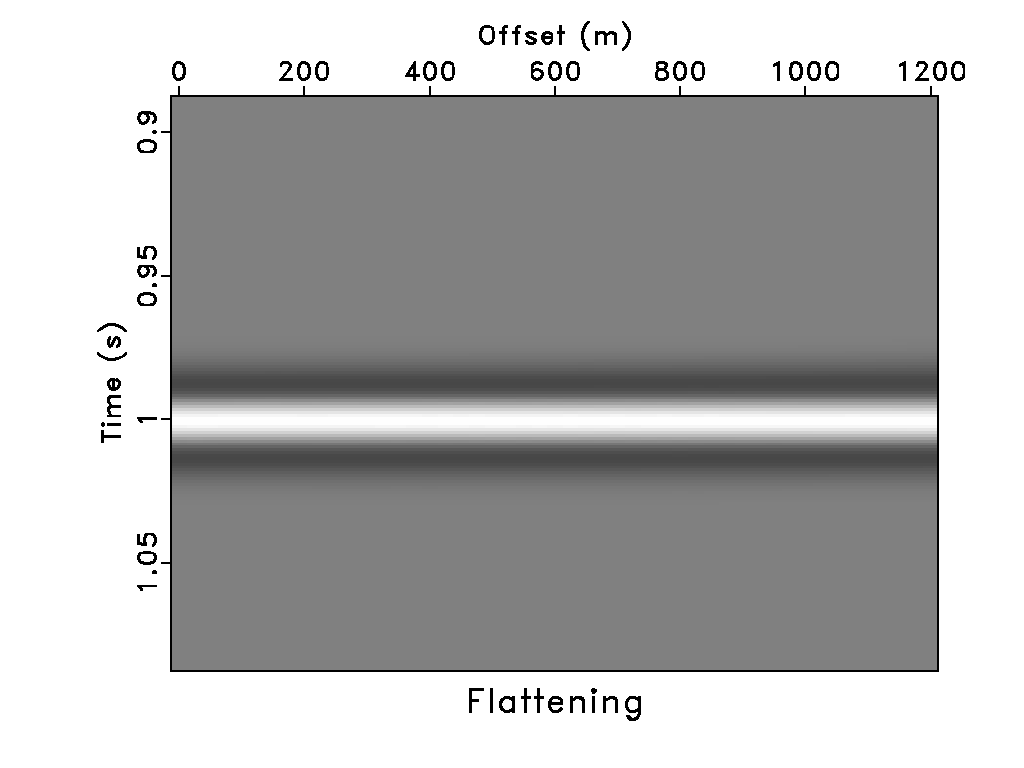

In [62]:
view('flat')

## Velocity estimation by time warping

Predictive painting produces $t_0(t,x)$. Time warping converts it into $t(t_0,x)$.

In [19]:
%%file twarp.scons

Flow('twarp','paint','math output=x1 | iwarp warp=$SOURCE')

Result('twarp','window j1=20 | transp | graph yreverse=y min2=0.888 max2=1.088 pad=n title="Time Warping" ')

Overwriting twarp.scons


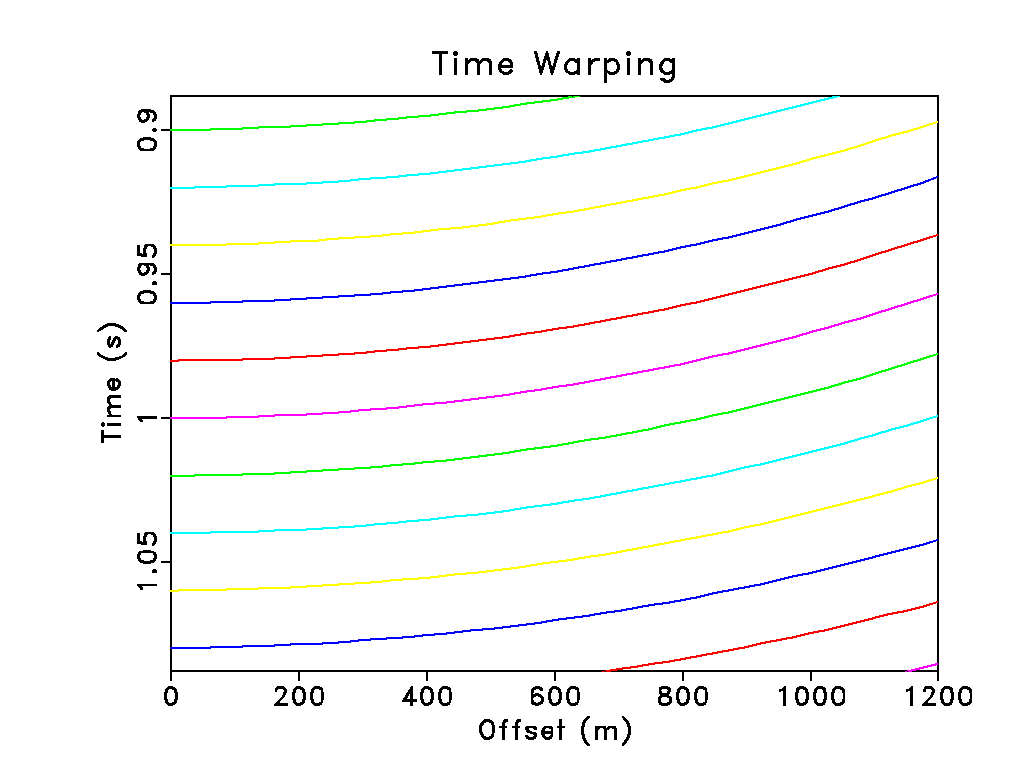

In [20]:
view('twarp')

We now want to fit 

$t^2(t_0,x)-t_0^2 \approx \Delta S\,x^2$, 

where $\Delta S = \frac{1}{v^2} - \frac{1}{v_0^2}$.

The least-squares fit is 

$\Delta S = \displaystyle \frac{\int x^2\left[t^2(t_0,x)-t_0^2\right]\,dx}{\int x^4\,dx}$.

The velocity estimate is

$v = \displaystyle \frac{v_0}{\sqrt{\Delta S\,v_0^2 + 1}}$.

In [37]:
%%file lsfit.scons

Flow('num','twarp','math output="(input*input-x1*x1)*x2^2" | stack norm=n')
Flow('den','twarp','math output="x2^4" | stack norm=n')
Flow('vel','num den','div ${SOURCES[1]} | math output="1800/sqrt(1800*1800*input+1)" ')

Result('vel',
       '''
       window f1=888 n1=200 | 
       graph yreverse=y transp=y title="Estimated Velocity" label2=Velocity unit2=m/s grid2=y pad=n min2=1950 max2=2050
       ''')

Overwriting lsfit.scons


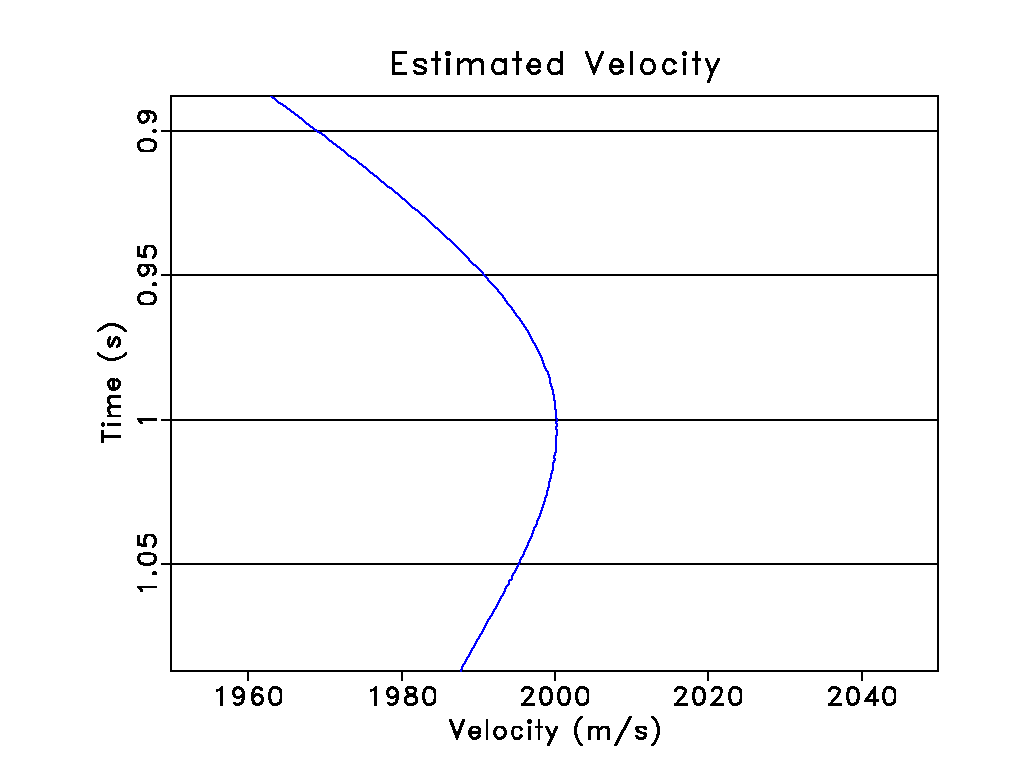

In [38]:
view('vel')

## Last step - physical flattening

In [39]:
%%file nmo2.scons

Flow('nmo2','gather vel','nmo half=n velocity=${SOURCES[1]}')

Result('nmo2','window f1=888 n1=200 | grey title="Physical Flattening" ')

Writing nmo2.scons


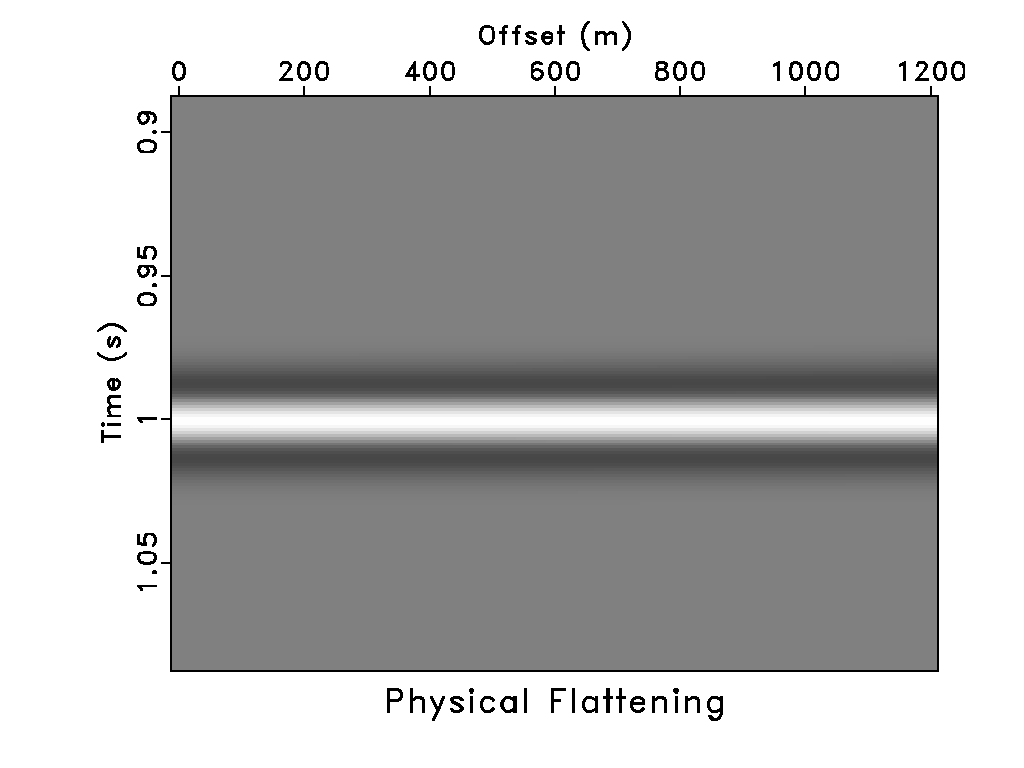

In [40]:
view('nmo2')